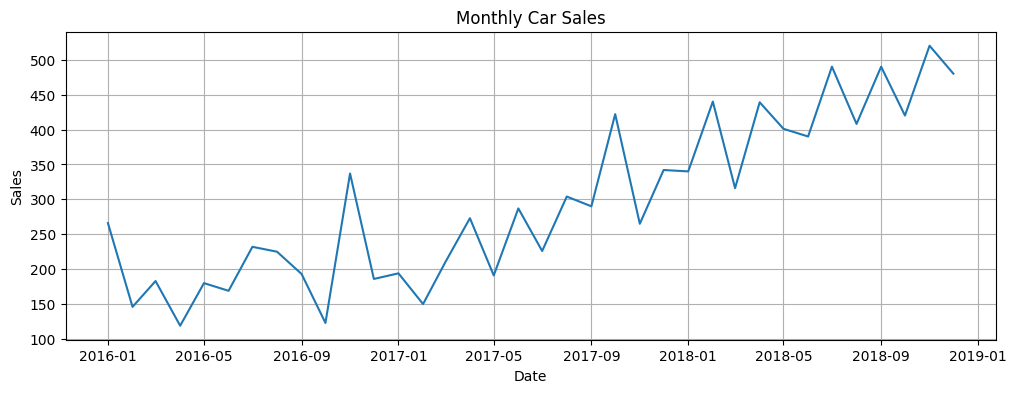

ADF Statistic: 1.636883157269031
p-value: 0.9979641164504948
ADF Statistic: -1.383201254047557
p-value: 0.5903026282170575
Differencing order (d): 2


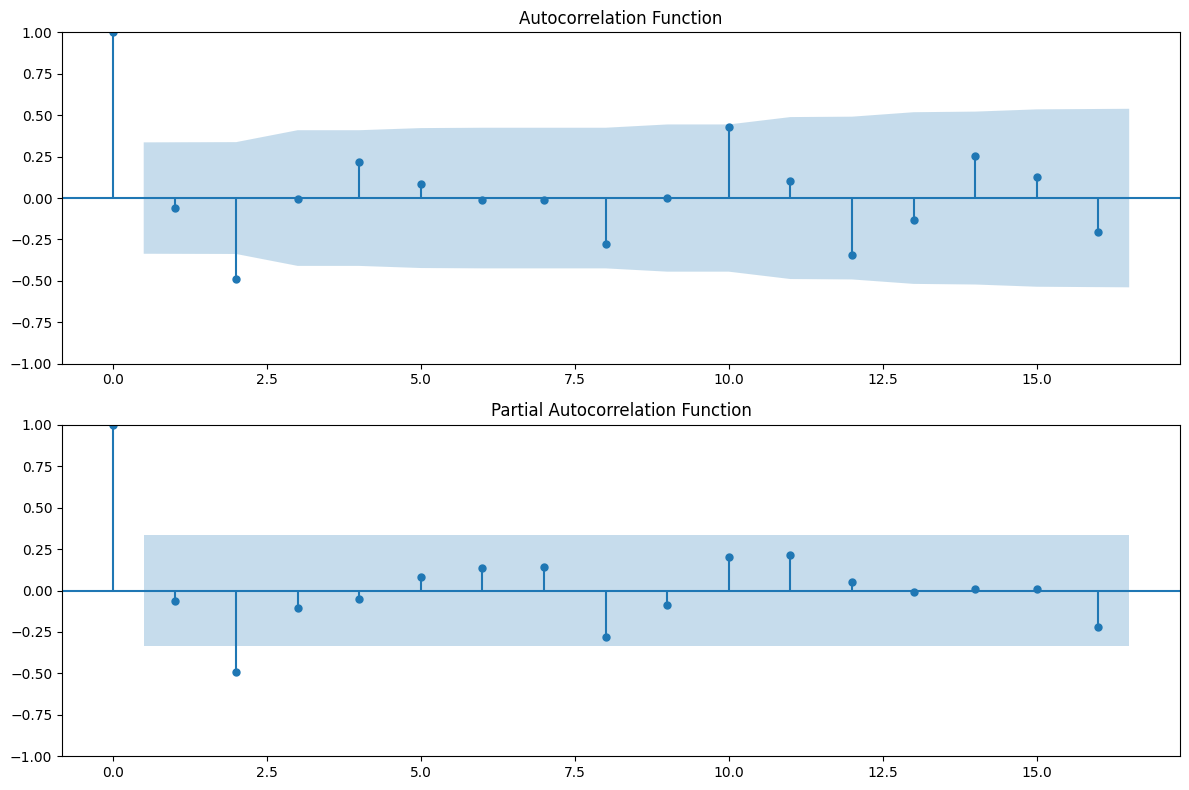


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -190.954
Date:                Wed, 09 Apr 2025   AIC                            387.907
Time:                        06:50:47   BIC                            392.486
Sample:                    01-01-2016   HQIC                           389.469
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7149      0.142     -5.032      0.000      -0.993      -0.436
ma.L1         -0.9972      2.999     -0.332      0.740      -6.876       4.881
sigma2      3809.6616   1.12e+

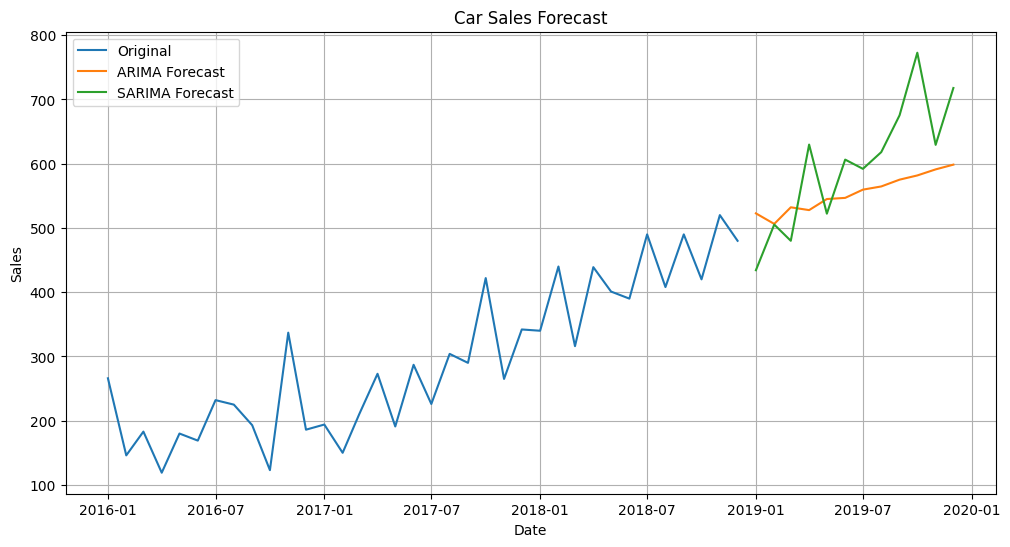


ARIMA RMSE: 41.39
SARIMA RMSE: 61.07


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess the dataset
df = pd.read_csv('/content/sales-cars.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
value_col = 'Sales'

# Function to check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    return result[1] <= 0.05

# Plot the original time series
plt.figure(figsize=(12, 4))
plt.plot(df[value_col])
plt.title('Monthly Car Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# Determine differencing order
is_stationary = check_stationarity(df[value_col])
d = 0
if not is_stationary:
    diff_series = df[value_col].diff().dropna()
    is_stationary = check_stationarity(diff_series)
    d = 1
    if not is_stationary:
        diff_series = diff_series.diff().dropna()
        d = 2

print(f'Differencing order (d): {d}')

# ACF and PACF plots
plt.figure(figsize=(12, 8))
plt.subplot(211)
plot_acf(df[value_col].diff(d).dropna(), ax=plt.gca())
plt.title('Autocorrelation Function')

plt.subplot(212)
plot_pacf(df[value_col].diff(d).dropna(), ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

# ARIMA model
p, q = 1, 1
arima_model = ARIMA(df[value_col], order=(p, d, q))
arima_results = arima_model.fit()
print('\nARIMA Model Summary:')
print(arima_results.summary())

# SARIMA model with seasonal order
P, D, Q, s = 1, 1, 1, 12
sarima_model = SARIMAX(df[value_col],
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit()
print('\nSARIMA Model Summary:')
print(sarima_results.summary())

# Forecast next 12 months
forecast_steps = 12
arima_forecast = arima_results.forecast(steps=forecast_steps)
sarima_forecast = sarima_results.forecast(steps=forecast_steps)

# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(df[value_col], label='Original')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.plot(sarima_forecast, label='SARIMA Forecast')
plt.title('Car Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE for model comparison
train_size = int(len(df) * 0.8)
train, test = df[value_col][:train_size], df[value_col][train_size:]

arima_pred = arima_results.predict(start=train_size, end=len(df)-1)
sarima_pred = sarima_results.predict(start=train_size, end=len(df)-1)

arima_rmse = np.sqrt(np.mean((test - arima_pred) ** 2))
sarima_rmse = np.sqrt(np.mean((test - sarima_pred) ** 2))

print(f'\nARIMA RMSE: {arima_rmse:.2f}')
print(f'SARIMA RMSE: {sarima_rmse:.2f}')